In [28]:
import os
import os.path
import cv2
import glob
import imutils
from helpers import resize_to_fit
import numpy as np
import tensorflow as tf
import operator
import logging
import time
from PIL import Image

logging.getLogger("tensorflow").setLevel(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [29]:
def storeInDictionary(pl, topValue, dikt):
    
                if pl in dikt.keys() :
                        dikt[pl] = dikt[pl] + topValue
                else:
                        dikt[pl] = topValue
                return dikt     


In [30]:
test_dict={
        0: "2", 1: "3", 2: "4", 3: "5", 4: "6", 5: "7", 6: "8", 7: "9", 8: "A",
        9: "a", 10: "B", 11: "C", 12: "D", 13: "E", 14: "F", 15: "G", 16: "g",
        17: "H", 18: "I", 19: "J", 20: "K", 21: "a", 22: "b", 23: "c", 24: "d",
        25: "e", 26: "f", 27: "g", 28: "h", 29: "j", 30: "k", 31: "m", 32: "n",
        33: "p", 34: "q", 35: "r", 36: "s", 37: "t", 38: "u", 39: "v", 40: "w",
        41: "x", 42: "y", 43: "z", 44: "M", 45: "N", 46: "P", 47: "Q", 48: "R",
        49: "S", 50: "T", 51: "U", 52: "V", 53: "W", 54: "X", 55: "Y", 56:"Z"
        }

test_data = np.empty(shape = (1, 35, 25, 1), dtype=np.float)
top_n_predictions = 3

model_path = "model/image_classification"
solved_images = 'D:/Internship/captcha/TENSORFLOW CODE/solved'
CAPTCHA_IMAGE_FOLDER_fourth = "D:/Internship/captcha/TENSORFLOW CODE/fourth/*.png"
CAPTCHA_IMAGE_FOLDER_middle = "D:/Internship/captcha/TENSORFLOW CODE/middle/*.png"
CAPTCHA_IMAGE_FOLDER_gap = "D:/Internship/captcha/TENSORFLOW CODE/gap/*.png"
CAPTCHA_IMAGE_FOLDER_dark = "D:/Internship/captcha/TENSORFLOW CODE/dark/*.png"

# Get a list of all the captcha images we need to process
captcha_image_files_fourth = glob.glob(CAPTCHA_IMAGE_FOLDER_fourth)
captcha_image_files_middle = glob.glob(CAPTCHA_IMAGE_FOLDER_middle)
captcha_image_files_gap = glob.glob(CAPTCHA_IMAGE_FOLDER_gap)
captcha_image_files_dark = glob.glob(CAPTCHA_IMAGE_FOLDER_dark)

counts = {}
took_list = []

In [33]:
def images(captcha_image_files):
    vcount = 0
    tcount=0
    # loop over the image paths
    for (file_count, captcha_image_file) in enumerate(captcha_image_files):
        print("[INFO] processing image {}/{}".format(file_count + 1, len(captcha_image_files)))

        # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
        # grab the base filename as the text
        filename = os.path.basename(captcha_image_file)
        captcha_correct_text = os.path.splitext(filename)[0]

        # Load the image and convert it to grayscale
        image = cv2.imread(captcha_image_file)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Add some extra padding around the image
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

        # threshold the image (convert it to pure black and white)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # find the contours (continuous blobs of pixels) the image
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Hack for compatibility with different OpenCV versions
        contours = contours[0] if imutils.is_cv2() else contours[1]

        letter_image_regions = []
        merged_letter_image_regions = []
        final_letter_image_regions = []
        # Now we can loop through each of the four contours and extract the letter
        # inside of each one

        for contour in contours:
            # Get the rectangle that contains the contour
            (x, y, w, h) = cv2.boundingRect(contour)
            if  w>3 and h>7:
                letter_image_regions.append((x, y, w, h))

        letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

        # add some padding  on the last value of letter image region
        lastone = (letter_image_regions[-1][0], letter_image_regions[-1][1], letter_image_regions[-1][2] + 2, letter_image_regions[-1][3])
        letter_image_regions[-1] = lastone

        regions_length = len(letter_image_regions)
        merged_letter_image_regions = []
        i=0
        widths = []
        smallest_top_left = []
        largest_bottom_right = []
        merged_candidates = []
        new_width = 0
        while i < regions_length:
            if i+1 == regions_length:
                    if letter_image_regions[i] not in  merged_letter_image_regions: 
                        merged_letter_image_regions.append(letter_image_regions[i])
                        widths.append(letter_image_regions[i][2])
                    break

            adjacent_region_gap = letter_image_regions[i+1][0] - letter_image_regions[i][0]
            if(adjacent_region_gap<=8):
                if(i not in merged_candidates):
                    merged_candidates.append(i)
                    smallest_top_left.append(letter_image_regions[i][1])
                    largest_bottom_right.append(letter_image_regions[i][3])
                if(i+1 not in merged_candidates):
                    merged_candidates.append(i+1)
                    smallest_top_left.append(letter_image_regions[i+1][1])
                    largest_bottom_right.append(letter_image_regions[i+1][3])
                i+=2
            else:
                if letter_image_regions[i] not in  merged_letter_image_regions :
                    merged_letter_image_regions.append(letter_image_regions[i])
                    widths.append(letter_image_regions[i][2]) 

    #            merged_letter_image_regions.append(letter_image_regions[i+1])    
    #            widths.append(letter_image_regions[i+1][2]) 
                i+=1

        if len(merged_candidates)>1:

            new_x = 0
            new_x += letter_image_regions[merged_candidates[-1]][0] + letter_image_regions[merged_candidates[-1]][2]
            new_width = new_x - letter_image_regions[merged_candidates[0]][0] + 4
            widths.append(new_width)    
            new_region = (letter_image_regions[merged_candidates[0]][0], min(smallest_top_left), new_width, max(largest_bottom_right))    
            merged_letter_image_regions.append(new_region)

        average_width = sum(widths)/4
        merged_letter_image_regions = sorted(merged_letter_image_regions, key=lambda x: x[0])
        if average_width<=20:
            offset = 1
            loop = 6
            delta_threshold = 3
        else:
            offset = 1
            loop = 8
            delta_threshold = 4

        tcount+=1
        # If we found more or less than 4 letters in the captcha, our letter extraction
        # didn't work correcly. Skip the image instead of saving bad training data!

        if len(merged_letter_image_regions) <4:

            final_letter_image_regions = []
            for letter_bounding_box in merged_letter_image_regions:
                # Grab the coordinates of the letter in the image
                x, y, w, h = letter_bounding_box

                if w/average_width> 3.5:
                    half_width = int(w / 4)
                    final_letter_image_regions.append((x, y, half_width, h))
                    final_letter_image_regions.append((x + half_width, y, half_width, h)) 
                    final_letter_image_regions.append((x + 2*half_width, y, half_width, h))        
                    final_letter_image_regions.append((x + 3*half_width, y, half_width, h))        
                elif w/average_width> 2.39:
                    half_width = int(w / 3)
                    final_letter_image_regions.append((x, y, half_width, h))
                    final_letter_image_regions.append((x + half_width, y, half_width, h)) 
                    final_letter_image_regions.append((x + 2*half_width, y, half_width, h))
                elif w/average_width> 1.5:
                    half_width = int(w / 2)
                    final_letter_image_regions.append((x, y, half_width, h))
                    final_letter_image_regions.append((x + half_width, y, half_width, h))
                else:
                    # This is a normal letter by itself
                    final_letter_image_regions.append((x, y, w, h))
        else:
            final_letter_image_regions = merged_letter_image_regions

        final_letter_image_regions2 = []
        if len(final_letter_image_regions) == 2:

            for letter_bounding_box in final_letter_image_regions:
            # Grab the coordinates of the letter in the image
                x, y, w, h = letter_bounding_box
                half_width = int(w / 2)
                final_letter_image_regions2.append((x, y, half_width, h))
                final_letter_image_regions2.append((x + half_width, y, half_width, h))
            final_letter_image_regions = final_letter_image_regions2
            
        if len(final_letter_image_regions) == 3:
            start_x = 0
            for i in range(1,len(final_letter_image_regions)):
                start_x  = final_letter_image_regions[i-1][0] +  final_letter_image_regions[i-1][2]
                delta_w = final_letter_image_regions[i][0] - start_x
                if delta_w >10:
                    new_char = (start_x, final_letter_image_regions[i][1], delta_w, final_letter_image_regions[i][3])
                    final_letter_image_regions.append(new_char)

        if len(final_letter_image_regions) != 4:
            large_contours = []
            raw_letter_image_regions = []
            for contour in final_letter_image_regions:
                x, y, w, h = contour
                if  w>3 and h>7:
                    large_contours.append(contour)
                    raw_letter_image_regions.append((x, y, w, h))

            raw_letter_image_regions = sorted(raw_letter_image_regions, key=lambda x: x[0])

            startx = raw_letter_image_regions[0][0]
            endx = raw_letter_image_regions[-1][0] + raw_letter_image_regions[-1][2] 

            raw_letter_image_regions = sorted(raw_letter_image_regions, key=lambda x: x[1])
            starty = raw_letter_image_regions[0][1]

            max_height = sorted(raw_letter_image_regions, key=lambda x:x[-1])[-1][-1]
            endy = raw_letter_image_regions[-1][1] + max_height     
            maxy = endy-starty

            char_width = ((endx-startx)/4)+2      
            letter_image_regions1 = []
            for i in range(4):       
                letter_image_regions1.append((startx+i*char_width, starty, char_width, maxy))

            final_letter_image_regions = sorted(letter_image_regions1, key=lambda x: x[0])

        final_letter_image_regions = sorted(final_letter_image_regions, key=lambda x: x[0])
        output = cv2.merge([gray] * 3)
        predictions = [] 
        loaded_graph = tf.Graph()
        
        with tf.Session(graph=loaded_graph) as sess:

            # Load model
            loader = tf.train.import_meta_graph(model_path + '.meta')
            loader.restore(sess, model_path)

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('x:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')

            for letter_bounding_box in final_letter_image_regions:
        #        # Grab the coordinates of the letter in the image
                x, y, w, h = letter_bounding_box

                delta_width = 0
                loop_counter = 0
                dikt = {}
                output = cv2.rectangle(output, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 255, 0), 1)

                while True:

                    if x-delta_width>=0 and y-2>=0:
                        letter_image = gray[y-2:y + h + 2, int(x-delta_width):int(x + w-delta_width)]
                    elif x-delta_width>=0 and y-1>=0:
                        letter_image = gray[y-1:y + h + 2, int(x-delta_width):int(x + w-delta_width)]
                    else:
                        letter_image = gray[y:y + h + 2, int(x):int(x + w-delta_width)]

                    if(letter_image.shape[1] == 0 or letter_image.shape[0]==0) :
                        break

                    letter_image = resize_to_fit(letter_image, 25, 35)
                    arr = np.array(letter_image)
                    arr = arr.astype(float)
                    arr = arr*1/arr.max()
                    test_data[0,:, :, 0] = arr

                    random_test_predictions = sess.run(
                            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
                            feed_dict={loaded_x: test_data, loaded_keep_prob: 1.0})

                    if delta_width < delta_threshold and delta_width >= 0:
                        delta_width = delta_width + offset
                    elif delta_width >= delta_threshold:
                        delta_width = - offset
                    else:
                        delta_width = delta_width - offset

                    topValue = random_test_predictions.values[0,0]
                    topValue2 = random_test_predictions.values[0,1]
                    topValue3 = random_test_predictions.values[0,2]

                    pl = random_test_predictions.indices[0,0]
                    pl2 = random_test_predictions.indices[0,1]
                    pl3 = random_test_predictions.indices[0,2]

                    loop_counter += 1

                    dikt = storeInDictionary(pl, topValue, dikt)
                    dikt = storeInDictionary(pl2, topValue2, dikt)
                    dikt = storeInDictionary(pl3, topValue3, dikt)

                    pl = test_dict[pl]
                    if loop_counter >= loop:
                        pl = max(dikt.items(), key=operator.itemgetter(1))[0]
                        predictions.append(test_dict[pl])
                        break
            sess.close()
        p = os.path.join(solved_images, "{}".format(filename))
        cv2.imwrite(p, output)
        display(Image.open(p))
        captcha_text = "".join(predictions)
        print("Actual Text:", captcha_correct_text)
        print("Predicted Text: ",captcha_text)
        if (np.char.lower(captcha_text) == np.char.lower(captcha_correct_text)):
            print("...........................................................MATCH...............................................................")
            vcount+=1
            print("matches so far : {}/{}".format(vcount,tcount))

    print("Accuracy:>>>>>>>>> ", vcount/tcount )



[INFO] processing image 1/20


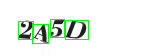

Actual Text: 2A5D
Predicted Text:  2A5D
...........................................................MATCH...............................................................
matches so far : 1/1
[INFO] processing image 2/20


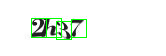

Actual Text: 2h37
Predicted Text:  2h37
...........................................................MATCH...............................................................
matches so far : 2/2
[INFO] processing image 3/20


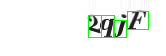

Actual Text: 2qjf
Predicted Text:  2qJF
...........................................................MATCH...............................................................
matches so far : 3/3
[INFO] processing image 4/20


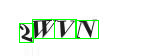

Actual Text: 2WVN
Predicted Text:  2WVN
...........................................................MATCH...............................................................
matches so far : 4/4
[INFO] processing image 5/20


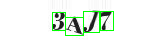

Actual Text: 3AJ7
Predicted Text:  3AJ7
...........................................................MATCH...............................................................
matches so far : 5/5
[INFO] processing image 6/20


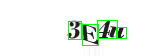

Actual Text: 3E4u
Predicted Text:  3E4t
[INFO] processing image 7/20


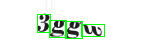

Actual Text: 3ggw
Predicted Text:  3ggw
...........................................................MATCH...............................................................
matches so far : 6/7
[INFO] processing image 8/20


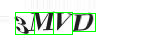

Actual Text: 3MVD
Predicted Text:  3MVD
...........................................................MATCH...............................................................
matches so far : 7/8
[INFO] processing image 9/20


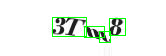

Actual Text: 3Tm8
Predicted Text:  7wn8
[INFO] processing image 10/20


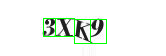

Actual Text: 3XK9
Predicted Text:  3XK9
...........................................................MATCH...............................................................
matches so far : 8/10
[INFO] processing image 11/20


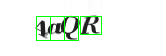

Actual Text: 4aQR
Predicted Text:  4aQR
...........................................................MATCH...............................................................
matches so far : 9/11
[INFO] processing image 12/20


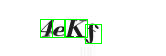

Actual Text: 4ekf
Predicted Text:  4eKf
...........................................................MATCH...............................................................
matches so far : 10/12
[INFO] processing image 13/20


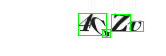

Actual Text: 4GZV
Predicted Text:  KJZv
[INFO] processing image 14/20


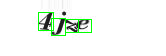

Actual Text: 4JZE
Predicted Text:  4Jze
...........................................................MATCH...............................................................
matches so far : 11/14
[INFO] processing image 15/20


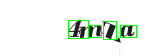

Actual Text: 4mza
Predicted Text:  4n7a
[INFO] processing image 16/20


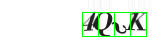

Actual Text: 4QvK
Predicted Text:  4QvK
...........................................................MATCH...............................................................
matches so far : 12/16
[INFO] processing image 17/20


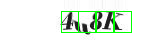

Actual Text: 4u8k
Predicted Text:  4xnC
[INFO] processing image 18/20


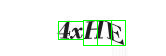

Actual Text: 4xHE
Predicted Text:  aXDE
[INFO] processing image 19/20


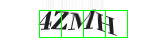

Actual Text: 4zmh
Predicted Text:  YAHP
[INFO] processing image 20/20


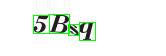

Actual Text: 5bsq
Predicted Text:  5Bsq
...........................................................MATCH...............................................................
matches so far : 13/20
Accuracy:>>>>>>>>>  0.65


In [34]:
images(captcha_image_files_gap)

[INFO] processing image 1/20


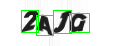

Actual Text: 2AJG
Predicted Text:  2AJG
...........................................................MATCH...............................................................
matches so far : 1/1
[INFO] processing image 2/20


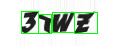

Actual Text: 37WZ
Predicted Text:  37WZ
...........................................................MATCH...............................................................
matches so far : 2/2
[INFO] processing image 3/20


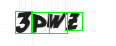

Actual Text: 3PWZ
Predicted Text:  3PWZ
...........................................................MATCH...............................................................
matches so far : 3/3
[INFO] processing image 4/20


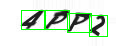

Actual Text: 4PP2
Predicted Text:  4PP2
...........................................................MATCH...............................................................
matches so far : 4/4
[INFO] processing image 5/20


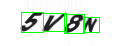

Actual Text: 5V8N
Predicted Text:  5V8N
...........................................................MATCH...............................................................
matches so far : 5/5
[INFO] processing image 6/20


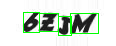

Actual Text: 6ZJM
Predicted Text:  6ZJM
...........................................................MATCH...............................................................
matches so far : 6/6
[INFO] processing image 7/20


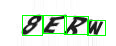

Actual Text: 8ERW
Predicted Text:  8ERW
...........................................................MATCH...............................................................
matches so far : 7/7
[INFO] processing image 8/20


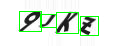

Actual Text: 9JKZ
Predicted Text:  9JKZ
...........................................................MATCH...............................................................
matches so far : 8/8
[INFO] processing image 9/20


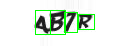

Actual Text: AB7R
Predicted Text:  AB7R
...........................................................MATCH...............................................................
matches so far : 9/9
[INFO] processing image 10/20


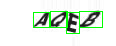

Actual Text: AQEB
Predicted Text:  AQEB
...........................................................MATCH...............................................................
matches so far : 10/10
[INFO] processing image 11/20


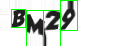

Actual Text: BM29
Predicted Text:  BM29
...........................................................MATCH...............................................................
matches so far : 11/11
[INFO] processing image 12/20


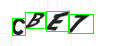

Actual Text: CBE7
Predicted Text:  CBE7
...........................................................MATCH...............................................................
matches so far : 12/12
[INFO] processing image 13/20


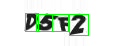

Actual Text: D5F2
Predicted Text:  D5T2
[INFO] processing image 14/20


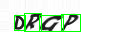

Actual Text: DRGP
Predicted Text:  DRCP
[INFO] processing image 15/20


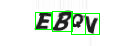

Actual Text: EBQV
Predicted Text:  EBQV
...........................................................MATCH...............................................................
matches so far : 13/15
[INFO] processing image 16/20


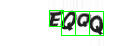

Actual Text: EQQQ
Predicted Text:  EQQQ
...........................................................MATCH...............................................................
matches so far : 14/16
[INFO] processing image 17/20


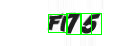

Actual Text: FI75
Predicted Text:  H7C7
[INFO] processing image 18/20


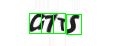

Actual Text: G7TS
Predicted Text:  C7TS
[INFO] processing image 19/20


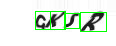

Actual Text: GKSR
Predicted Text:  GKSR
...........................................................MATCH...............................................................
matches so far : 15/19
[INFO] processing image 20/20


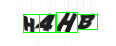

Actual Text: H4HB
Predicted Text:  H4HB
...........................................................MATCH...............................................................
matches so far : 16/20
Accuracy:>>>>>>>>>  0.8


In [35]:
images(captcha_image_files_fourth)

[INFO] processing image 1/20


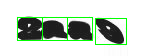

Actual Text: 2aa9
Predicted Text:  2aa9
...........................................................MATCH...............................................................
matches so far : 1/1
[INFO] processing image 2/20


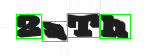

Actual Text: 2sTh
Predicted Text:  2STh
...........................................................MATCH...............................................................
matches so far : 2/2
[INFO] processing image 3/20


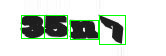

Actual Text: 35n7
Predicted Text:  35n7
...........................................................MATCH...............................................................
matches so far : 3/3
[INFO] processing image 4/20


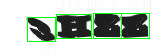

Actual Text: 3HZZ
Predicted Text:  3HZZ
...........................................................MATCH...............................................................
matches so far : 4/4
[INFO] processing image 5/20


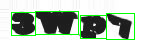

Actual Text: 3Wp7
Predicted Text:  3Wp7
...........................................................MATCH...............................................................
matches so far : 5/5
[INFO] processing image 6/20


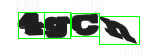

Actual Text: 4gcn
Predicted Text:  4gCn
...........................................................MATCH...............................................................
matches so far : 6/6
[INFO] processing image 7/20


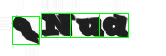

Actual Text: 4Nud
Predicted Text:  4Nud
...........................................................MATCH...............................................................
matches so far : 7/7
[INFO] processing image 8/20


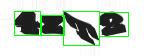

Actual Text: 4zt2
Predicted Text:  4ZT2
...........................................................MATCH...............................................................
matches so far : 8/8
[INFO] processing image 9/20


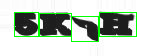

Actual Text: 5K7H
Predicted Text:  5K7H
...........................................................MATCH...............................................................
matches so far : 9/9
[INFO] processing image 10/20


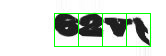

Actual Text: 62vt
Predicted Text:  62Vt
...........................................................MATCH...............................................................
matches so far : 10/10
[INFO] processing image 11/20


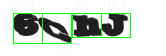

Actual Text: 6ChJ
Predicted Text:  6ChJ
...........................................................MATCH...............................................................
matches so far : 11/11
[INFO] processing image 12/20


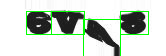

Actual Text: 6va8
Predicted Text:  6VA8
...........................................................MATCH...............................................................
matches so far : 12/12
[INFO] processing image 13/20


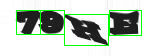

Actual Text: 79HE
Predicted Text:  79HE
...........................................................MATCH...............................................................
matches so far : 13/13
[INFO] processing image 14/20


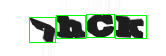

Actual Text: 7hCk
Predicted Text:  7hCK
...........................................................MATCH...............................................................
matches so far : 14/14
[INFO] processing image 15/20


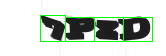

Actual Text: 7PzD
Predicted Text:  7PZD
...........................................................MATCH...............................................................
matches so far : 15/15
[INFO] processing image 16/20


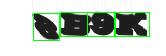

Actual Text: 8B9K
Predicted Text:  8B9K
...........................................................MATCH...............................................................
matches so far : 16/16
[INFO] processing image 17/20


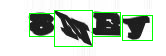

Actual Text: 8NEy
Predicted Text:  8NEy
...........................................................MATCH...............................................................
matches so far : 17/17
[INFO] processing image 18/20


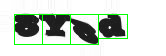

Actual Text: 8Y8d
Predicted Text:  8Y8d
...........................................................MATCH...............................................................
matches so far : 18/18
[INFO] processing image 19/20


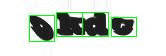

Actual Text: 9kdc
Predicted Text:  9KdC
...........................................................MATCH...............................................................
matches so far : 19/19
[INFO] processing image 20/20


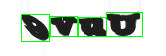

Actual Text: 9vuU
Predicted Text:  9VuU
...........................................................MATCH...............................................................
matches so far : 20/20
Accuracy:>>>>>>>>>  1.0


In [36]:
images(captcha_image_files_dark)

[INFO] processing image 1/20


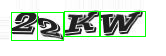

Actual Text: 22KW
Predicted Text:  22KW
...........................................................MATCH...............................................................
matches so far : 1/1
[INFO] processing image 2/20


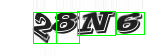

Actual Text: 28N6
Predicted Text:  28N6
...........................................................MATCH...............................................................
matches so far : 2/2
[INFO] processing image 3/20


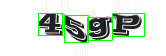

Actual Text: 45gp
Predicted Text:  45gP
...........................................................MATCH...............................................................
matches so far : 3/3
[INFO] processing image 4/20


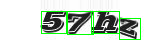

Actual Text: 57hz
Predicted Text:  57hZ
...........................................................MATCH...............................................................
matches so far : 4/4
[INFO] processing image 5/20


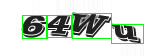

Actual Text: 64wu
Predicted Text:  64Wu
...........................................................MATCH...............................................................
matches so far : 5/5
[INFO] processing image 6/20


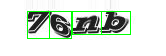

Actual Text: 76nb
Predicted Text:  76nb
...........................................................MATCH...............................................................
matches so far : 6/6
[INFO] processing image 7/20


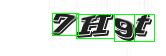

Actual Text: 7H9t
Predicted Text:  7H9t
...........................................................MATCH...............................................................
matches so far : 7/7
[INFO] processing image 8/20


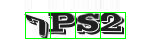

Actual Text: 7PS2
Predicted Text:  7PS2
...........................................................MATCH...............................................................
matches so far : 8/8
[INFO] processing image 9/20


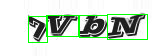

Actual Text: 7VbN
Predicted Text:  7VbN
...........................................................MATCH...............................................................
matches so far : 9/9
[INFO] processing image 10/20


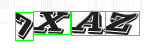

Actual Text: 7XAZ
Predicted Text:  7XAZ
...........................................................MATCH...............................................................
matches so far : 10/10
[INFO] processing image 11/20


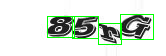

Actual Text: 85rG
Predicted Text:  85rG
...........................................................MATCH...............................................................
matches so far : 11/11
[INFO] processing image 12/20


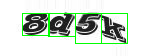

Actual Text: 8d5k
Predicted Text:  8d5K
...........................................................MATCH...............................................................
matches so far : 12/12
[INFO] processing image 13/20


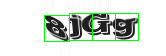

Actual Text: 8jGg
Predicted Text:  8rXg
[INFO] processing image 14/20


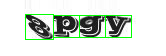

Actual Text: 8pgy
Predicted Text:  8pgy
...........................................................MATCH...............................................................
matches so far : 13/14
[INFO] processing image 15/20


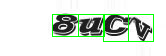

Actual Text: 8ucv
Predicted Text:  8uCV
...........................................................MATCH...............................................................
matches so far : 14/15
[INFO] processing image 16/20


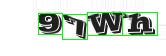

Actual Text: 97Wh
Predicted Text:  97Wh
...........................................................MATCH...............................................................
matches so far : 15/16
[INFO] processing image 17/20


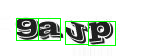

Actual Text: 9aJP
Predicted Text:  9aJp
...........................................................MATCH...............................................................
matches so far : 16/17
[INFO] processing image 18/20


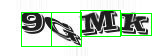

Actual Text: 9GMk
Predicted Text:  9GMK
...........................................................MATCH...............................................................
matches so far : 17/18
[INFO] processing image 19/20


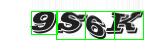

Actual Text: 9S6K
Predicted Text:  9S6K
...........................................................MATCH...............................................................
matches so far : 18/19
[INFO] processing image 20/20


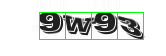

Actual Text: 9W93
Predicted Text:  9W93
...........................................................MATCH...............................................................
matches so far : 19/20
Accuracy:>>>>>>>>>  0.95


In [37]:
images(captcha_image_files_middle)